# Language analysis of written texts.

Let's start with implementing the function lang_confidence_score(word_counts, language_words_with_frequency). \
\
The function calculates the score by giving the sum of the product of the number of apperances of a word in the analyzed text and the frequency of the word in a given language, divided by the number of words in the text. Then, the language which scored the highest is the closest match for the language of the source text.

I'll also create an assisting function create_text(text) which will be used for turning the source texts into dictionaries.

In [1]:
from modules.controller import Controller
from assets.arg_classes import Args, WordCountArgs

import os
import json

def lang_confidence_score(word_counts: dict, language_words_with_frequency: list):
    # I assume that language_words_with_frequency contains pairs of [word, word_frequency_in_lang]
    result = 0
    sum_word_counts = 0
    frequency_dict = dict(language_words_with_frequency)

    for word, count in word_counts.items():
        sum_word_counts += count
        result += count * frequency_dict.get(word, 0)
    return result / sum_word_counts

def create_dict(text: str):
    word_count = {}

    # creating a temporary controller to use its _clean_up_word functionality
    temp_controller = Controller(
        Args(count_args=WordCountArgs(count_words="temp"))
    )

    list_of_words = text.split()

    for index in range(0, len(list_of_words)):
        list_of_words[index] = temp_controller._clean_up_word(list_of_words[index])
        word = list_of_words[index]

        if word and word.lower() in word_count:
            word_count[word.lower()] += 1
        elif word:
            word_count[word.lower()] = 1
    return word_count


### Let's prepare the data needed to perform the analysis. 
For the languages I'll choose English, German and Polish.
The Spore Wiki dictionaries will be made from the "Spore" and "Maxis" articles. The source texts for each of the chosen languages will be as follows:
- for the English language I chose Shakespeare's "Macbeth"
- for the German language I chose Marx's "The Communist Manifesto"
- for the Polish language I chose the first volume of Sienkiewicz's "Potop"

In [2]:
from wordfreq import top_n_list, word_frequency

# creating the list of the most commonly used words in each language
most_common_en = top_n_list("en", 3000)

# the frequency lists are already sorted because the words are taken from the most_common list
en_frequency = []
for word in most_common_en:
    en_frequency.append([word, word_frequency(word, "en")])

most_common_de = top_n_list("de", 3000)

de_frequency = []
for word in most_common_de:
    de_frequency.append([word, word_frequency(word, "de")])

most_common_pl = top_n_list("pl", 3000)

pl_frequency = []
for word in most_common_pl:
    pl_frequency.append([word, word_frequency(word, "pl")])

spore_args = Args(
    count_args=WordCountArgs(count_words="Spore")
)

maxis_args = Args(
    count_args=WordCountArgs(count_words="Maxis")
)

controller1 = Controller(spore_args)
controller2 = Controller(maxis_args)

spore_dict = controller1.count_words(save_to_json=False)
maxis_dict = controller2.count_words(save_to_json=False)

with open("source_texts/macbeth.txt", "r") as f:
    macbeth_contents = f.read()

macbeth_dict = create_dict(macbeth_contents)

with open("source_texts/manifesto.txt", "r") as f:
    communist_contents = f.read()

communist_dict = create_dict(communist_contents)

with open("source_texts/potop.txt", "r") as f:
    potop_contents = f.read()

potop_dict = create_dict(potop_contents)

word_dictionaries = [spore_dict, maxis_dict, macbeth_dict, communist_dict, potop_dict]

### Now to present the lang_confidence_score function on the prepared data:

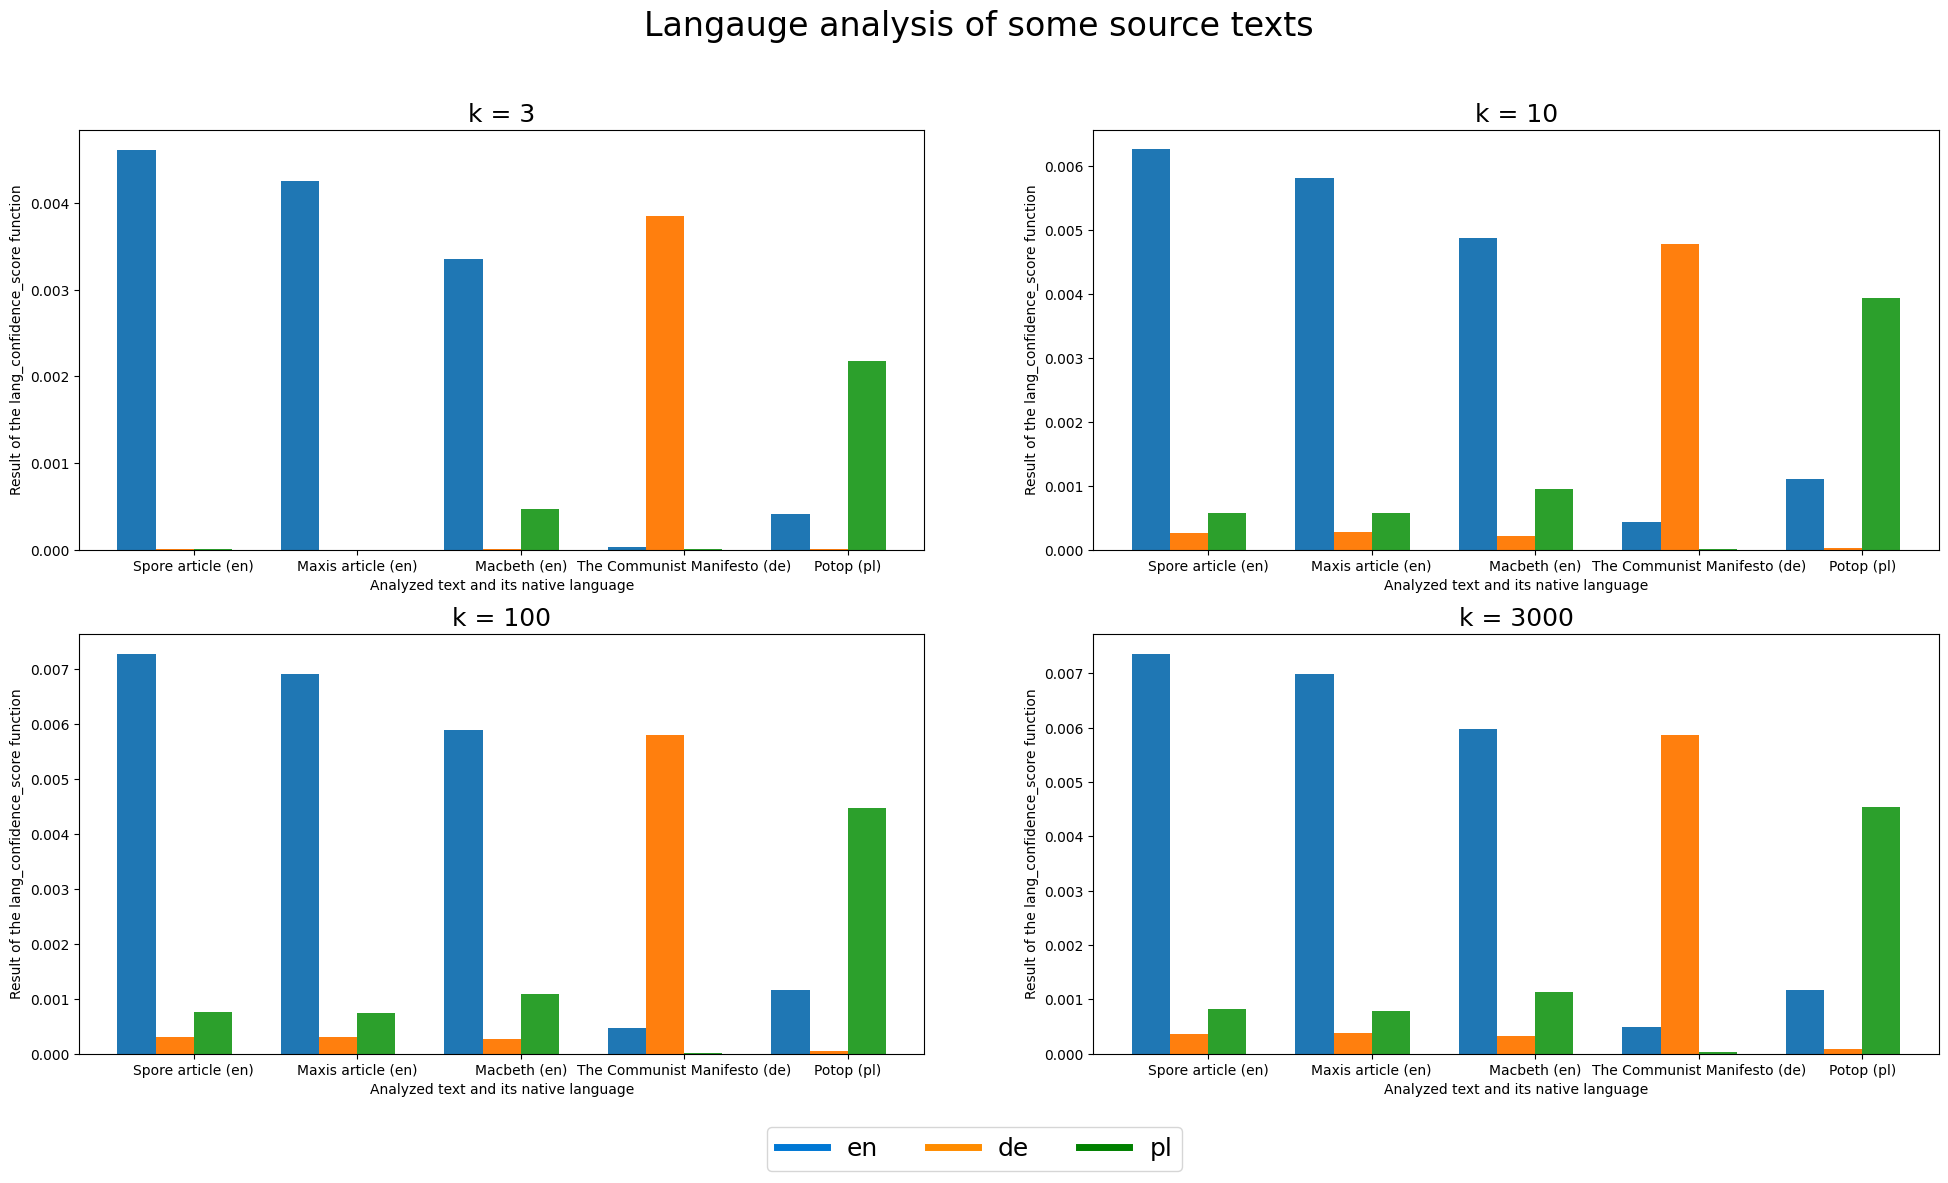

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np

k = [3, 10, 100, 3000]

scores = []

# calculating each score for every trial of k
for k_val in k:
    en_scores_k = []
    de_scores_k = []
    pl_scores_k = []
    
    for word_dict in word_dictionaries:
        en_scores_k.append(lang_confidence_score(word_dict, en_frequency[:k_val]))
        de_scores_k.append(lang_confidence_score(word_dict, de_frequency[:k_val]))
        pl_scores_k.append(lang_confidence_score(word_dict, pl_frequency[:k_val]))
    
    scores.append([
        en_scores_k,
        de_scores_k,
        pl_scores_k
    ])

# creating bar graphs showcasing the results, grouped by the k value
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(24, 12)
fig.suptitle("Langauge analysis of some source texts", fontsize=24)

legend_elements = [
    Line2D([0], [0], color="#0078D4", lw=5, label="en"),
    Line2D([0], [0], color="darkorange", lw=5, label="de"),
    Line2D([0], [0], color="green", lw=5, label="pl")
]
fig.legend(handles=legend_elements, loc="lower center", ncol=4, fontsize=18)

width_cluster = 0.7
width_bar = width_cluster / 3  # 3 is the number of the languages analyzed
index = ["Spore article (en)", "Maxis article (en)", "Macbeth (en)", "The Communist Manifesto (de)", "Potop (pl)"]

x = np.arange(len(index))

for axs_no in range(4):
    axs[axs_no // 2, axs_no % 2].set_title(f"k = {k[axs_no]}", fontsize=18)
    axs[axs_no // 2, axs_no % 2].set_xlabel("Analyzed text and its native language")
    axs[axs_no // 2, axs_no % 2].set_ylabel("Result of the lang_confidence_score function")
    for n in range(3):
        x_pos = x + (width_bar * n) - width_cluster / 2
        axs[axs_no // 2, axs_no % 2].bar(x_pos, scores[axs_no][n], width_bar, align="edge", tick_label=index)


### Conclusions:

- The lang_confidence_score function managed to correctly establish the language of each source text, given the three language categories.

- In the categories of articles written in English, especially for larger k, the lang_confidence_score gave a non-negligible score for the Polish language. That can be attributed to the usage of words like "on", "to" etc, which exist in both of the languages.

- The most outstanding difference in the lang_confidence_function scores between the first and the other languages is for "The Communist Manifesto", which is possibly because of the usage of umlauts in German which do not exist in Polish and English.

- For larger k, the score distribution for languages in categories based on English texts tends to look similar.

- There's very little overlap between the Polish and German languages, which could be caused by special non-latin letters in each of these languages, which do not exist in the other one.

So to summarize:

- The choice of languages did matter in that, for example, the English language and the Polish language shared some very short common words, which had an effect on the higher score values for Polish than German when analyzing an English text (and vice versa). Also, all the analyzed languages' alphabets are mostly based on the Latin script, which caused the word similarities.

- The "Potop" source text saw the highest rise in the value of the lang_confidence_score of any text by the increase of the k value, which could be attributed to the fact that many of the words in the Polish language are conjugated.

- It was difficult to find a Spore wiki article which minimized the score results for the Polish and German language, because for larger k some common words that appear in English (the wiki language) were also pretty prevalent in other languages ("to", "on", etc.).